<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Equilibrium Monte Carlo simulation of the 2D Ising model

## Examples - Statistical Mechanics
<section class="post-meta">
By Niels Henrik Aase, Eilif Sommer Øyre, Asle Sudbø, and Jon Andreas Støvneng
</section>
Last edited: TODAY

___
TING
___

## Introduction
The Ising model is perhaps the most thoroughly researched model in statistical physics. The main reasons for this is it's simplicity, and the fact that it has an analytical solution on a two dimensional infinite square lattice, which makes for an excellent benchmark for numerical calculation schemes. This solution [[1]](#rsc) was worked out by Nobel Laureate Lars Onsager in 1944, a former student at NTNU, which makes the project extra special for us at NumFys. The Ising model is the only nontrivial example of a phase transition that can be proven rigorously [[2]](#rsc). However, the proof is way beyond the scope of both this project.

For the curious reader, the derivation of the specific heat can be found in the paper of Lars Onsager [[1]](#rsc). The expression for the spontaneous magnetization was also found by Onsager, but the derivation of this expression was never published. Onsager simply stated it on a conference at Cornell University in 1948, and four years later Ying published a derivation of the same result [[3]](#rsc).

## Theory

### Ising model

The Ising model has already been discussed in a previous [notebook](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/ising_model.ipynb), but some of the results bears repeating. The Ising model represents the magnetic dipole moments of atomic spins. The spins can be in two states, +1 or -1. The spins interact only with their nearest neighbor through an interaction parameter $J_{ij}$.

Consider an $ N \times N $ lattice, with $s_{i}$ denoting the spin at site $i$. We allow for different interactions along the columns and the rows of the lattice, where we denote the interaction between spins along rows as $J$ and between spins along columns $J'$. Without loss of generality, we assume that the magnetic field $\vec{B}$ is on the form $\vec{B} = (0 ,0 , B)$ and that the dipole moments are on the form $s_i = (0, 0, \pm 1)$. The Hamiltonian of the system then becomes 

\begin{equation}
H = - \sum_{<i,j>} J_{ij} s_i s_j - B\sum_{i} s_i,
\label{Hamiltonian}
\end{equation}
where $B$ is the magnetic field. The first summation is over nearest neighbors of each lattice point, while the second summation is over all the $N^2$ lattice points. The interaction between the nearest neighbors are described using $J$ and $J'$.

The partition function is then given by
\begin{equation}
Z = \sum_{\{s_i\}}  e^{-\beta H},
\label{Partition}
\end{equation}
where the summation is over the possible states of the system and $\beta$ is a Lagrange multiplier equal to $\frac{1}{k_B T}$. $k_B$ is the Boltzmann constant, and $T$ is the temperature. From now on, we set $k_B = 1$, such that $\beta$ is just inverse temperature. We also choose to mainly ignore the units of the calculated quantities.

The number of possible states increase unfathomably fast when we increase the size of the lattice. The summation contains $2^{N^2}$ terms, so for $N=6$ we need to sum over 68 719 476 736 spin configurations. In the previous [Ising model notebook](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/ising_model.ipynb), the sum was calculated exactly, and using a high-speed language such as Fortran, it is possible to simulate $5 \times 5$ lattices in a reasonable time. However, the Onsager solution is only valid for a $N \times \infty$ lattice, hence we need a different method for simulating larger systems that are of more interest. In this notebook we will use a Monte Carlo method, more specifically the Metropolis algorithm.


### The Metropolis algorithm
The Metropolis algorithm is the perhaps the most famous Monte Carlo algorithm. In our case we will use it to approximate the expectation values of the system, i.e. the macroscopic and measurable, values such as for example the specific heat, $c$, or the magnetization, $m$. We will split the explanation of the algorithm in two, first we will focus on the implementation of single Monte Carlo sweep, then we will explain how measurements of the system should be made. The latter is perhaps the most subtle and advanced part of the notebook.

#### Implementation
1. Initialize a spin configuration. In our case the initial spin configuration will be random, corresponding to a high temperature initial configuration.
2. Compute the energy of the configuration using \eqref{Hamiltonian}.
3. Pick a random site $i$ on the lattice, and calculate the energy of the configuration if $s_i \rightarrow   -s_i$. Then compute the change in energy of the whole configuration, $\Delta E$.
4. If $\Delta E$ is negative, accept the change of the spin-configuration by letting $s_i \rightarrow   -s_i$.
5. If  $\Delta E$ is non-negative, generate a random number $r \in \big \langle 0, 1 \big \rangle$. If $e^{-\beta \Delta E} > r$, change the spin configuration by letting $s_i \rightarrow   -s_i$.
6. Repeat the process $N^2$ times. This defines a single Monte Carlo sweep, $t$.

To summarize, a move that reduces the energy of the spin configuration, $\textit{will}$ be accepted, while a move that increases the energy, $\textit{might}$ get accepted.

It is important to note that the random, non-deterministic, nature of Monte Carlo simulations means that even though two simulations have the same initial spin configuration and external parameters, the two simulations will evolve differently, so don't worry if your results vary from simulation to simulation.

Even though we are using a stochastic summation, this algorithm will be computationally demanding for larger system, its complexity scales as $N^2$. The total runtime of the program will be dominated by running an enormous amounts of Monte Carlo sweeps, in our case in the range of up to 400 000 sweeps for $N=512$, which corresponds to running the 1-5 steps above, $10^{11}$ times! If we in addition simulate for different temperatures, we are running the most basic parts of our algorithm trillions of times. This requires an extremely efficient Monte Carlo sweep function. Luckily, there is some things we can do in order to improve the runtime.

We are mainly concerned with computing the mean magnetization per spin of the system $m$, given by

$$ 
<m> = \frac{1}{N^2} \sum_{i}<s_i>, 
$$
and the specific heat at constant field $C_B$ per spin. Trough classical statistical physics and thermodynamics, $C_B$ can be shown to be equal to

$$
\frac{C_B}{k_B} = \big[ \langle (\beta H )^2 \rangle - \langle (\beta H) \rangle ^2 \big] = \mathrm{Var}[\beta H]. 
$$

This fantastic and surprising result show that the specific heat is completely determined by energy fluctuations (i.e. the variance of the energy of the system)!

Let us start with the simplest case, the mean magnetization per spin, $m$. In order to calculate this, we calculate the magnetization of the lattice after each sweep and then calculate the average value. However, this requires that the sum $\sum_{i} s_i$ needs to be calculated $N^2$ times per sweep, which is a far too time consuming operation. This operation can be simplified greatly by noting that the change in $m$ only depends on the change in spin at the random site $k$,  $s_k \rightarrow   -s_k$. Denoting the new and old state of the system as $\nu$ and $\mu$, we observe that

\begin{equation}
\Delta m = m_{\nu} - m_{\mu} = \sum_{i} s_i^{\nu} - \sum_{i} s_i^{\mu} = s_k^{\nu} - s_k^{\mu} = 2 s_k^{\nu}, 
\label{Delta_m}
\end{equation}

where $s_k^{\nu}$ and $s_k^{\mu}$ denote the spin at site $k$ after and before the spin has been changed. Thus we only need to calculate $m$ once, then each time a spin is flipped, i.e  $s_k \rightarrow   -s_k$, we find the updated magnetization by 

$$
m_{\nu} = m_{\mu} + 2 s_k^{\nu}.
$$

The change in energy is slightly more difficult, but the same principle applies, each time a spin changes, it only affects the spin configuration locally, we don't need to reconsider the entire lattice. From equation \eqref{Hamiltonian} we can calculate the change in the energy

$$
\Delta E = E_{\nu} - E_{\mu} = - \sum_{<i,j>} J_{ij} s_i^{\nu} s_j^{\nu} - B\sum_{i} s_i^{\nu} + \sum_{<i,j>} J_{ij} s_i^{\mu} s_j^{\mu} + B\sum_{i} s_i^{\mu} = - \big( \sum_{i \, \mathrm{ n.n\, to } \, k} J_{ik} s_i^{\mu} (s_k^{\nu} - s_k^{\mu}) \big) - 2 B s_k^{\nu}, 
$$
where we used equation \eqref{Delta_m} to evaluate the summations involving $B$. The nearest neighbor interactions are more complicated, but we observe that only the nearest neighbors of site $k$ are relevant for calculating $\Delta E $, all other interactions are canceled. The expression can be shortened even further by noting that $(s_k^{\nu} - s_k^{\mu}) = - 2 s_k^{\mu}$, and that $s_k^{\mu}$ can be pulled outside the sum. The final expression for $\Delta E$ can then be expressed as 

\begin{equation}
\Delta E = s_k^{\mu} \big( \sum_{i \, \mathrm{ n.n\, to } \, k} J_{ik} s_i^{\mu}\big) - 2 B s_k^{\nu}.
\label{Delta_E}
\end{equation}

The simplifications are valid in any number of dimensions, where the number of dimensions determine the number of terms in the summation. In our case where we consider a two-dimensional system, the summation contains four terms.

You might notice that almost all of the computations only involve integers, the only exceptions being the random number $r$ and the exponentials. For a given combination of $J$, $J'$ and $B$ there is a finite number of possible values of $\Delta E$, thus one can save the possible exponential values $e^{-\beta \Delta E}$ at the start of the simulation, so for any $\Delta E$ we know $e^{-\beta \Delta E}$ without having to calculate it! This is not done in our code, but it would improve the runtime even further because all calculations, with the exception of $r$, would only involve integers, which are normally much faster then calculations with real numbers.  

As mentioned earlier, almost all of the runtime will be spent running this algorithm up to 400 000 times. The algorithm has a time complexity that scales as $O(N²)$ , so the code must be extremely efficient. That is why have chosen to run this part of the code through Fortran, which yields superior computational speed, improving the runtime by a factor of 200. For completeness, we also show how one would implement the algorithm in Python, as it easier to understand how the algorithm works in a high level language such as Python.


## Python implementation
As we will see later there only exists a analytical solution for the thermodynamic quantities on an infinite lattice. Lars Onsager's solution is only valid for $B = 0$, and a analytic solution for $B \neq 0$ has yet to be found. For this reason, we choose to set $B=0$, as well as setting $J = J' = 1$.

In [4]:
# Imporing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
from scipy.special import ellipk, ellipe
%matplotlib inline

# Setting appropiate figure sizes
params = {'legend.fontsize': 26,
          'figure.figsize': (15, 15),
         'axes.labelsize': 26,
         'axes.titlesize': 26,
         'xtick.labelsize': 20,
         'ytick.labelsize': 20,
          'figure.titlesize': 28}
plt.rcParams.update(params)


def Ham(S, B= 0, J_v= 1, J_p=1):
    """
     Given a lattice configuration (i.e. a spin matrix) S, and the parameters B, J_v and J_p, this functions
     returns the energy of the lattice.
        
        Parameters:
        S: Spin matrix, (NxN) array
        B, J_v, J_p: Interactation and external parameters
        Returns:
            E: Energy of the lattice
    """
    B_contribution = B * np.sum(S) # Energy of the spin configuration resulting from an external magnetic field
    
    # Using np.roll here automatically satisifies the periodic boundary conditions.
    J_v_contribution = J_v * np.sum(S * np.roll(S, 1, axis= 0)) # Energy resulting from lattice interactions along columns
    J_p_contribution = J_p * np.sum(S * np.roll(S, 1, axis= 1)) # Energy resulting from lattice interactions along rows
    E = - (J_v_contribution + J_p_contribution + B_contribution)
    return E


def del_Ham(S, i, k, N, B = 0, J_v = 1, J_p = 1):
    """
    Calculates the energy change of the lattice if lattice site S[i][k] changes it's spin, in accordance
    to the simplifications in the theory part.
        
        Parameters:
        S: Spin matrix, (NxN) array
        i, k: indicates the lattice site
        N: Number of columns and rows in the lattice
        B, J_v, J_p: Interactation and external parameters
        Returns:
            del_E: The energy change
        """
    # Here we use the modulo operator to accomodate the PBCs
    nn = J_p * (S[(i + 1) % N][k] + S[i][(k + 1) % N] + J_v * (S[i - 1][k] + S[i][k - 1]))
    del_E = 2 * S[i][k] * (nn + B)
    return del_E


def Attempt_flip(S, beta, i, k, N, r, B = 0, J_v = 1, J_p = 1):
    """
    The central part of the Metropolis algorithm. Calculates the energy change at a random lattice site, and
    updates the spin of the lattice site in accordance to the rules of the Metropolis algorithm. Returns
    True/False on whether the spin should flip as well as the change in energy.
    
        Parameters:
        S: Spin matrix, (NxN) array
        beta: Inverse temperature
        i, k: indicates the lattice site
        N: Number of columns and rows in the lattice
        r: Random number between 0 and 1
        B, J_v, J_p: Interactation and external parameters
        Returns:
            del_E: The energy change
            flip : Boolean value on wheter the spin should be flipped.
        """
    del_E = del_Ham(S, i, k, N, B, J_v, J_p)
    if del_E <= 0:
        flip = True # If the energy change is negative, the spin flips
        return flip, del_E
    else:
        flip = np.exp(-beta * del_E) > r # The flip might flip, depending on r and the temperature
        return flip, del_E



def sweep(S, beta, N, B = 0, J_v = 1, J_p = 1):
    """
    A full Monte Carlo sweep. Runs the previous functions N ** 2 times, while always storing the updated change in
    magnetization and energy. Returns the updated spin configuaration and the change in magnetization and
    energy (with respect to the initial values).
    
        Parameters:
        S: Spin matrix, (NxN) array
        beta: Inverse temperature
        N: Number of columns and rows in the lattice
        B, J_v, J_p: Interactation and external parameters
        Returns:
            S: Updated spin configuartion after one Monte Carlo sweep
            del_He_sweep: Change in energy after one Monte Carlo sweep
            del_m_sweep: Change in magnetization after one Monte Carlo sweep
        """
    del_m_sweep = 0
    del_He_sweep = 0
    # Generating random numbers to genereate random lattice sites 
    rand_list_index_1 = np.random.randint(N, size=N ** 2)
    rand_list_index_2 = np.random.randint(N, size=N ** 2)
    # Generating N ** 2 random numbers between 0 and 1
    rand_numbers = np.random.rand(N**2)
    for l in range(N ** 2):
        i = rand_list_index_1[l]
        k = rand_list_index_2[l]
        check, del_E = Attempt_flip(S, beta, i, k, N, rand_numbers[l], B, J_v, J_p)
        if check:
            del_m = (-2) * S[i][k] / (N ** 2)
            S[i][k] *= (-1)
        else:
            del_m = 0
            del_E = 0
        del_He_sweep += del_E
        del_m_sweep += del_m
    return S, del_He_sweep, del_m_sweep



def compute_quantities(S, beta, M, B = 0, J_v = 1, J_p = 1, show_time= False):
    """
    Given the number of wanted sweeps, M, the simulation is ran for M Monte Carlo sweeps. Returns arrays with
    the values of magnetization and energy after each sweep.
    
        Parameters:
        S: Spin matrix, (NxN) array
        beta: Inverse temperature
        M: Number of Monte Carlo sweeps
        B, J_v, J_p: Interactation and external parameters
        Returns:
            He_list: The energy after each sweep (Mx1) array
            m_list : The magnetization after each sweep (Mx1) array
        """
    start = time.time()
    N = np.shape(S)[0]
    He_list = np.zeros(M)
    He_list[0] = Ham(S, B, J_v, J_p) # Initial energy of the lattice
    m_list = np.zeros(M)
    m_list[0] = np.sum(S) / N ** 2 # Iniitial magnetization of the lattice
    for j in range(1, M):
        S, del_He_sweep, del_m_sweep = sweep(S, beta, N, B, J_v, J_p)
        He_list[j] = He_list[j-1] + del_He_sweep # Storing the updated energy
        m_list[j] = m_list[j-1] + del_m_sweep # Storing the updated magnetization
    if show_time:
        print("Iteration time with T: ", 1 / beta, "\t", time.time() - start)
    return He_list, m_list



Iteration time with T:  1.0 	 96.68260145187378


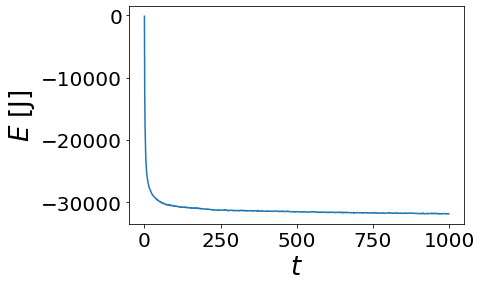

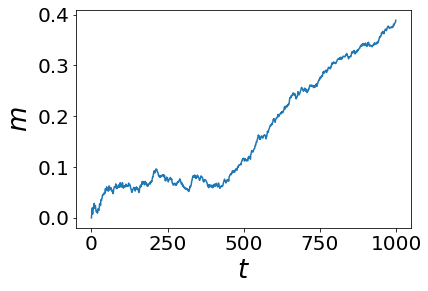

In [5]:
N = 128
S = 2 * np.random.randint(2, size=(N, N))-1 # Quick way to generate a random initial spin configuration
He_list, m_list = compute_quantities(S, 1, 1000, show_time= True)

step_list = np.arange(0, 1000)
plt.plot(step_list, He_list)
plt.xlabel(r"$t$") # t is the number of Monte Carlo sweeps
plt.ylabel(r"$E$ [J]")
plt.show()

plt.plot(step_list, m_list)
plt.xlabel(r"$t$")
plt.ylabel(r"$m$")
plt.show()

## Fortran implementation
As we can see above, running 1000 sweeps on a  $128 \times 128$ lattice is quite time consuming. In addition the magnetization fails to stabilize within the first 1000 sweeps so it is clear that we need to run more  sweeps.  . There is further optimizations that can be done with the code, but we will simply implement the same functionality in Fortran in order to obtain sufficient computational speed.

The Fortran code can be found HERE. For more information on how to call Fortran scripts from Python, check out our guide [here](https://www.numfys.net/howto/F2PY/).


In [2]:
# Testing that imported fortran code works
import ising_Monte
print(ising_Monte.__doc__)

This module 'ising_Monte' is auto-generated with f2py (version:2).
Functions:
  del_he_sweep,del_m_sweep,s = random_sweep(s_initial,beta,b,j_v,j_p,rand_numbers,rand_list_index1,rand_list_index2,n=shape(s_initial,0),n_squared=len(rand_numbers))
.
3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [16]:
# random_sweep from Fortran replaces the former sweep function written in Python

def compute_quantities_fortran(S, beta, M, B = 0, J_v = 1, J_p = 1, show_time = False):
    """
    Given the number of wanted sweeps, M, the simulation is ran for M Monte Carlo sweeps. Returns arrays with
    the values of magnetization and energy after each sweep. Calls the function random_sweep from Fortran.
    
        Parameters:
        S: Spin matrix, (NxN) array
        beta: Inverse temperature
        M: Number of Monte Carlo sweeps
        B, J_v, J_p: Interactation and external parameters
        Returns:
            He_list: The energy after each sweep (Mx1) array
            m_list : The magnetization after each sweep (Mx1) array
        """
    start = time.time()
    N = np.shape(S)[0]
    He_list = np.zeros(M)
    He_list[0] = Ham(S, B, J_v, J_p)
    m_list = np.zeros(M)
    m_list[0] = np.sum(S) / N ** 2
    S_f = np.copy(S)
    for j in range(1, M):
        rand_list_index1 = np.random.randint(1, N + 1, size= N ** 2) # Fortran is 1-indexed
        rand_list_index2 = np.random.randint(1, N + 1, size= N ** 2)
        rand_numbers = np.random.rand(N ** 2)
        del_He_sweep, del_m_sweep, S_f = ising_Monte.random_sweep(S_f, beta, B, J_v, J_p, rand_numbers, rand_list_index1, rand_list_index2, N, N ** 2)
        He_list[j] = He_list[j-1] + del_He_sweep
        m_list[j] = m_list[j-1] + del_m_sweep
    if show_time:
        print("Iteration time with T: ", 1 / beta, ": \t", time.time() - start, ", \t # iterations: ", M, ", \t N = ", N)
    return He_list, m_list


Iteration time with T:  1.0 : 	 0.5204474925994873 , 	 # iterations:  1000 , 	 N =  128


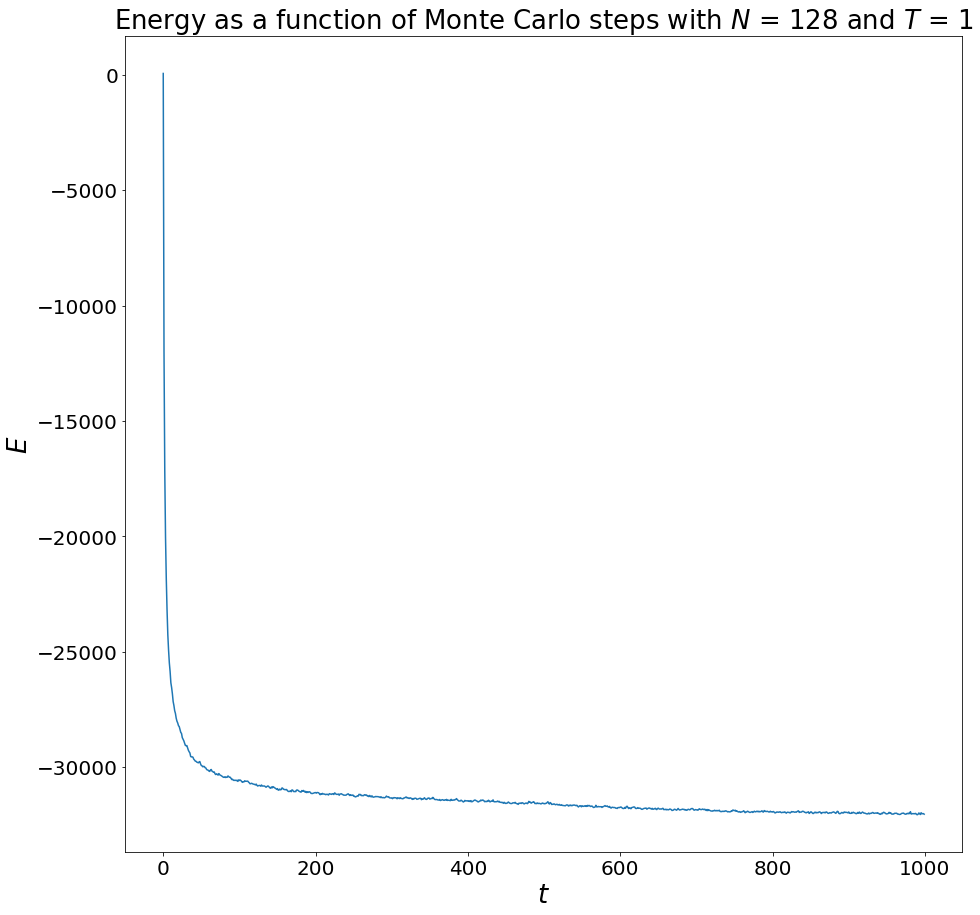

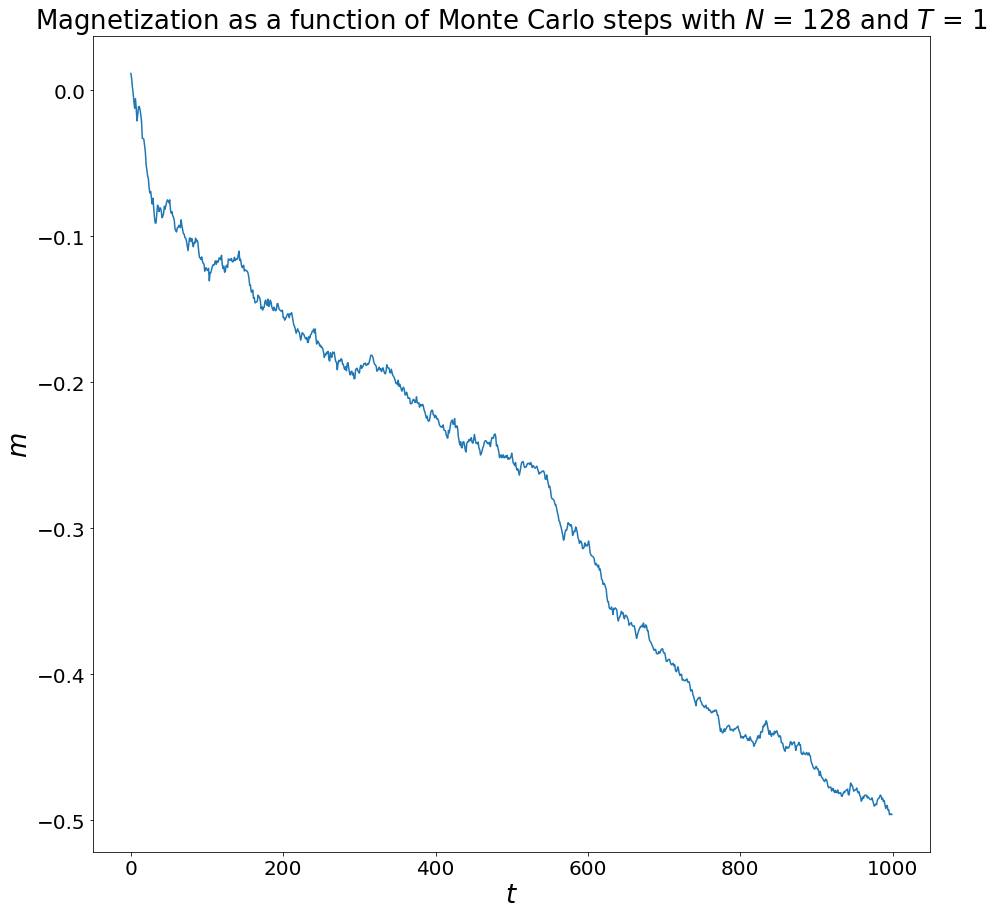

In [150]:
N = 128
S = 2 * np.random.randint(2, size=(N, N))-1
T = 1
He_list, m_list = compute_quantities_fortran(S, 1 / T, 1000, show_time=True)

step_list = np.arange(0, 1000)
plt.plot(step_list, He_list)
plt.title(r"Energy as a function of Monte Carlo steps with $N$ = {}".format(N) + " and $T$ = {}".format(T))
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.show()

plt.plot(step_list, m_list)
plt.title(r"Magnetization as a function of Monte Carlo steps with $N$ = {}".format(N) + " and $T$ = {}".format(T))
plt.xlabel(r"$t$")
plt.ylabel(r"$m$")
plt.show()

The runtime of the simulation is roughly 200 times faster than with Python, so it is safe to say that our Fortran function is an important tool for running big simulations.

# Measurements

#### Correlation time
Before we start calculating the interesting quantities, we need to determine how and when we should do measurements of the system. We are interested in the expectation values $ <m>, <E> and <E^2>$ and to find these values we use the average value as a the estimator. The average value is an unbiased estimator, but to obtain reliable results, the measurements must be independent. If we were to measure the magnetization and then measure it again only one Monte Carlo sweep later, it is clear that the two spin configurations will be correlated, a significant portion of the spins will not have changed. Therefore, we need to make sure that we wait long enough between the measurements to ensure that the spin configuration is significantly different from the state at the first measurement. By significantly different, we mean that the number of spins which are the same as in the initial state is no more than what you would expect to find just by chance [[4]](#rsc).

The number of Monte Carlo sweeps this process takes is defined as the correlation time $\tau$. It is related to the correlation in the following way. Let $\chi(t)$ be the autocorrelation function, it has a maximum value of 1, obtained at $t=0$, where the measurements are totally correlated. $t$ represents the number of Monte Carlo sweeps. The inverse would be if the system is exactly opposite of the initial configuration, making $\chi(t) = -1$. As $t$ increases, the correlation will drop as the current state (spin configuration) becomes less and less correlated. $\tau$ is related to $\chi(t)$ as 

\begin{equation}
\chi(t) \sim e^{- \frac{t}{\tau}}.
\label{corr_time}
\end{equation}

$\tau$ is thus a fitting parameter, which we can use the `scipy` library to determine the optimal fit. The most natural definition of statistical independent measurements is measurements made every $2\tau$. If we have ran $n$ Monte Carlo sweeps, we will have $m = \frac{n}{2\tau}$ independent measurements. A suitable estimator for $\chi$ for a measured quantity $O$ is given by, 

\begin{equation}
\chi_O(t) = \frac{1}{\chi_0} \frac{1}{n - t} \sum_{t' = 0}^{n - 1 -t} (O(t') - < O >_0 ) (O(t' + t) - < O >_t),
\label{corr_func}
\end{equation}

where $O(0), O(1), ..., O(n-1)$ is the $n$ measurements of $O$, and $\chi_0$ is defined such that $\chi(0) = 1$. $< O >_t)$ and $< O >_0)$ are defined as

\begin{equation}
< O >_0 = \frac{1}{n - t} \sum_{t' = 0}^{n - 1 -t} O(t') \quad \quad < O >_t = \frac{1}{n - t} \sum_{t' = 0}^{n - 1 -t} O(t' + t).
\label{help_sizes}
\end{equation}

Combining equations \eqref{corr_time} and \eqref{corr_func} we can make an estimate for $\tau$. In our case we only include the measurements that have positive autocorrelation such that $\chi_O(t) > 0$.
It must be noted that even if we only measure the physical quantities every $2\tau$, we still need to make a lot of measurements in order for our estimator to be close to the true value.


Lastly, we note that for extremely low temperatures, there will be almost no changes in spin configuration because the lattice has obtained it's lowest possible energy and it is highly unlikely that any spins flip due to thermal excitations. In this case we do not calculate the correlation time, and simply use all measurements.


In [7]:
def auto_corr_func(t, tau):
    """
    Dummy function declariation that is needed to use the curve_fit function from the scipy library. 
    
        Parameters:
        t: The enumuration of the Monte Carlo sweeps 
        tau: Correlation time
        Returns:
            chi: exp(-t / tau)
        """
    chi = np.exp(-t / tau)
    return chi


def correlation_time(arr):
    """
    Calculates the estimator for the autocorrelation function, chi, as a function of t. Stops the calculations
    of chi when chi(t) becomes egative. Then calculates the correlation time by using the curve_fit
    function from scipy-library.
    
        Parameters:
        arr: The measurement series we want to determine the correlation time of
        Returns:
            tau: The correlation time
            chi: The autocorrelation function as a function of # Monte Carlo sweeps. The size of the array varies.
        """
    chi = np.zeros(0)
    n = np.minimum(len(arr), 10000)
    # Here we take the minimum of the length of the array, and 10000 to obtain a correlation time that is
    # independant of the length of the array
    for t in range(n):
        frac = (1 / (n - t))
        
        # plus 1 to include last term
        expectation_0 = frac * np.sum(arr[:(n - 1 - t) + 1])
        expectation_t = frac * np.sum(np.roll(arr, - t)[:(n - 1 - t) + 1])
        
        temp = frac * np.sum((arr[:n - 1 - t + 1] - expectation_0) *
                             (np.roll(arr, - t)[:n - 1 - t + 1] - expectation_t))
        if temp < 0:
            break
        chi = np.append(chi, temp)
    # Normalize the autocorrelation function
    chi = chi / chi[0]
    t = np.arange(0, len(chi))
    # Calculates the correlation time with scipy
    tau = curve_fit(auto_corr_func, t, chi)[0]
    return tau[0], chi


It is instructive to see how the $\tau$ varies as a function of temperature. We also will see how well the curve fitting works. In this case the measured quantity $O$ corresponds to $m$, but the calculations are the same for all quantities.

Tau is equal to:  1139.04814499149  when T =  2.25


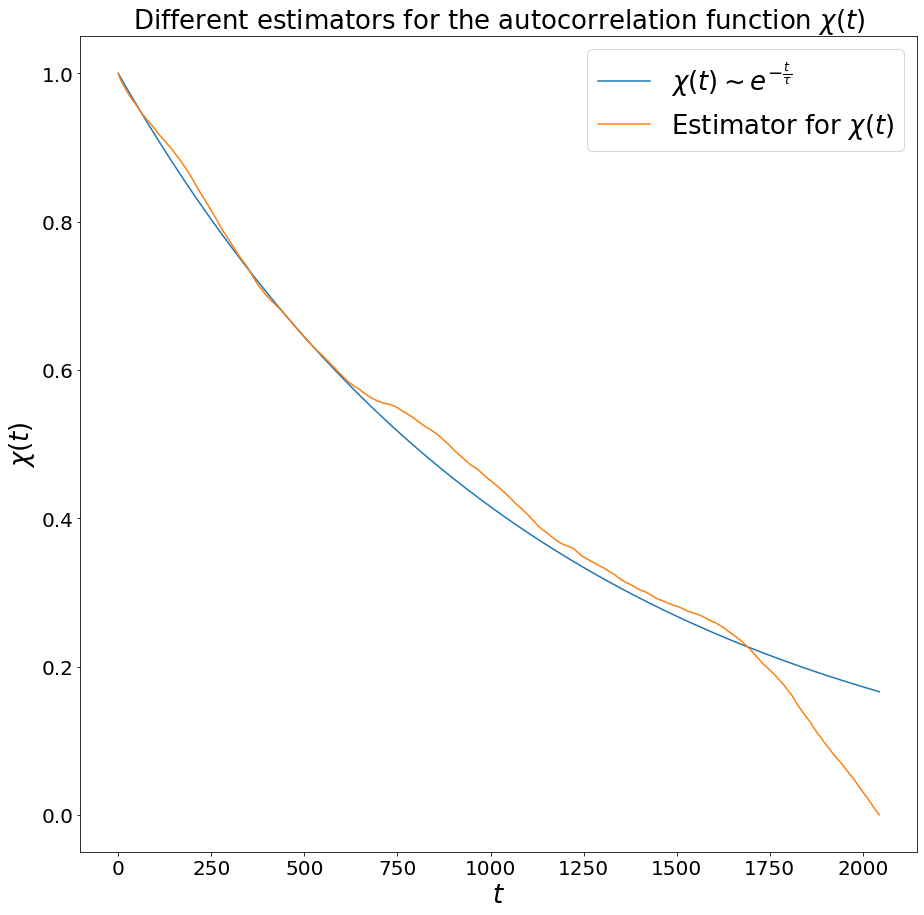

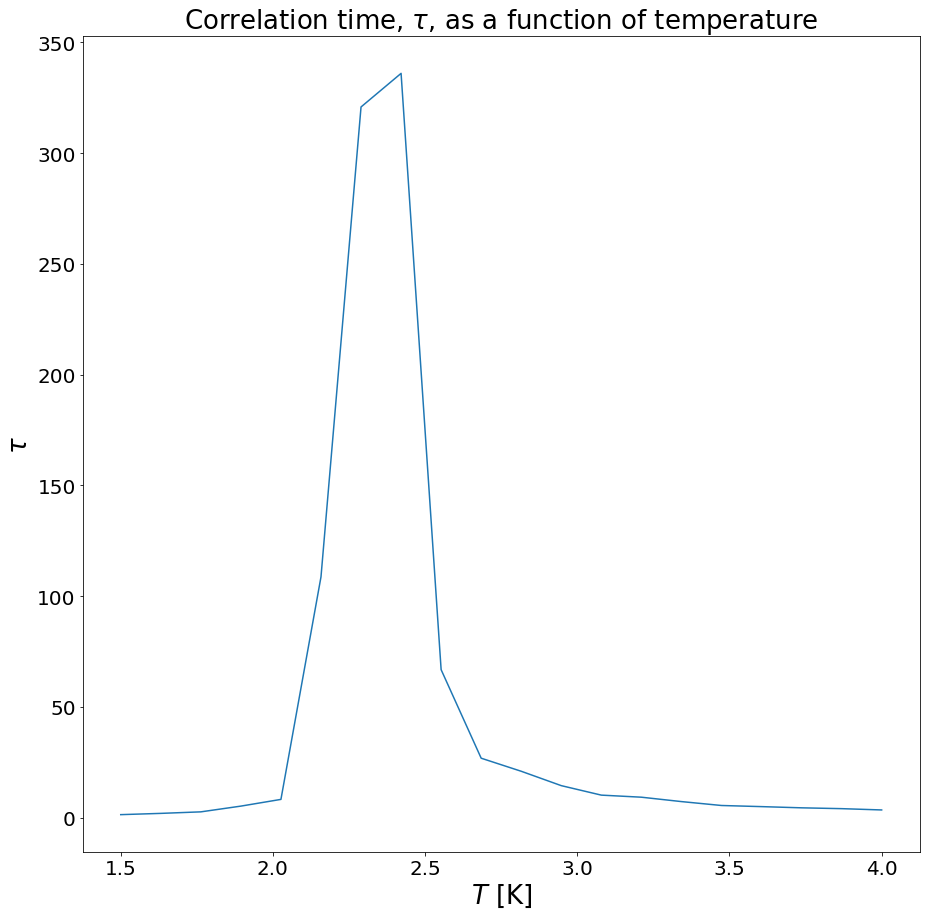

In [19]:
N = 128
S = 2 * np.random.randint(2, size=(N, N)) - 1
T = 2.25
m_list = compute_quantities_fortran(S, 1/T, 30000)[1]

tau, chi = correlation_time(m_list[20000:])
t = np.arange(len(chi))
plt.plot(t, np.exp(- t / tau), label= r"$\chi(t) \sim e^{- \frac{t}{\tau}}$")
plt.plot(t, chi, label = "Estimator for $\chi(t)$")
plt.legend()
plt.title(r"Different estimators for the autocorrelation function $\chi(t)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\chi(t)$")
plt.show()

T_list = np.linspace(1.5, 4, 20)
tau_list = np.zeros(0)
for T in T_list:
    beta = 1 / T
    # Why we differentiate cold and hot simulations is explained later
    if T < 2.5:
        m_list = compute_quantities_fortran(S, beta, 140000)[1]
        # The reason we only use the last 20000 values of the list is explained later
        tau, chi = correlation_time(m_list[120000:])

        tau_list = np.append(tau_list, tau)
    else:
        m_list = compute_quantities_fortran(S, beta, 40000)[1]
        # The reason we only use the last 20000 values of the list is explained later
        tau, chi = correlation_time(m_list[20000:])
        tau_list = np.append(tau_list, tau)
        

plt.plot(T_list, tau_list)
plt.title(r"Correlation time, $\tau$, as a function of temperature")
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$\tau$")
plt.show()

This figure illustrates the importance of using different correlation times for different temperatures. Notice the peak in the correlation time around $T=2.25$ K. As we will see later, this temperature is the critical temperature for the phase transition of the system. This effect is called "critical slowing down". The effect of the critical slowing down can be reduced by tweaking the on the Metropolis algorithm. More information on the topic can be found in chapter 4 in [[3]](#rsc). By determining $\tau$ for every simulation, we can extract as many independent measurements as possible from our system, thus minimizing the errors in our results.

### Equilibrium time
The last quantity we need to obtain before we can run the full Monte Carlo simulation is the equilibrium time $\tau_{\mathrm{eq}} $. $\tau_{\mathrm{eq}} $ is a measure on how many Monte Carlo sweeps that is necessary before the system has reached equilibrium. Luckily, the method of determining $\tau_{\mathrm{eq}} $ is far easier than determining $\tau$. We can simply run a small number of simulations for the same $T$ and see when the specified quantity ($m$ or $E$) starts to stabilize.

However, $\tau_{\mathrm{eq}} $ scales with $N$ and varies from simulation to simulation. One should always overestimate $\tau_{\mathrm{eq}} $ because our measurements are only valid when the system is in equilibrium, and starting to take measurements before this would make our results useless. Especially, at low temperatures $\tau_{\mathrm{eq}} $ could be enormous (as big as 100000 Monte Carlo sweeps). This happens when the system drops to a local energy minimum, and fails to further lower it's energy. It is important to note that $\tau_{\mathrm{eq}} $ will normally be low for low temperatures, but it $\textit{can}$ take a long time to reach equilibrium, thus we need to always overestimate $\tau_{\mathrm{eq}} $ to be on the safe side.

Below, we plot the magnetization as a function of Monte Carlo sweeps to illustrate how one can determine $\tau_{\mathrm{eq}} $.


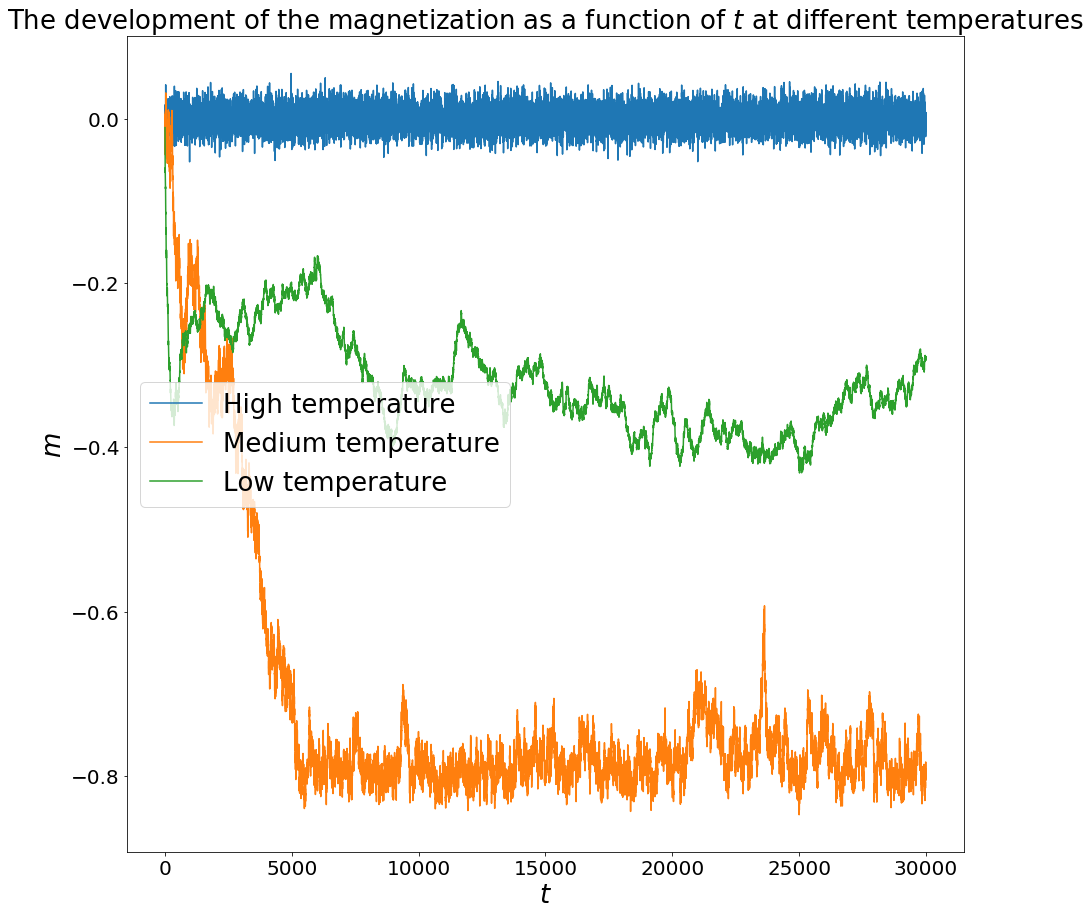

In [11]:
N = 128
S = 2 * np.random.randint(2, size=(N, N)) - 1

# High temperature
T = 5
beta = 1 / T
m_list = compute_quantities_fortran(S, beta, 30000)[1]
step_list = np.arange(30000)
plt.plot(step_list, m_list, label= "High temperature")


# Medium temperature
T = 2.2
beta = 1 / T
m_list = compute_quantities_fortran(S, beta, 30000)[1]
plt.plot(step_list, m_list, label= "Medium temperature")

# Low temperature
T = 1
beta = 1 / T
m_list = compute_quantities_fortran(S, beta, 30000)[1]
plt.plot(step_list, m_list, label= "Low temperature")


plt.xlabel(r"$t$")
plt.ylabel(r"$m$")
plt.title(r"The development of the magnetization as a function of $t$ at different temperatures")
plt.legend()
plt.show()

In high temperature case, we see that system is basically in equilibrium from the start of the simulation, while in the medium temperature case, the system reaches equilibrium after around 5000 sweeps. We also see an example where the system takes a lot of time to reach equilibrium. As a matter of fact, in the low temperature case, the system still has not reached equilibrium after 30000 sweeps. This illustrates the importance of using a high $\tau_{\mathrm{eq}} $. Luckily, we have tons of computational power at our disposal, so we can afford having a high $\tau_{\mathrm{eq}} $. Another important point is that the sign of the magnetization is not of any physical importance as long as there is no external field. If the magnetization is negative, one could simply rotate the entire system (turning it upside down) in order to have positive magnetization. Going forward, we will talk about the magnetization and the $\textit{magnitude}$ of the magnetization interchangeably.


## Full simulations
Let's finally incorporate all of our help functions and theory into a single function. 

In [8]:
def full_simulation(K, N, sweeps, T_min=1, T_max=4, B = 0, J_v = 1, J_p = 1, show_time = False):
    """
    Runs the full Monte Carlo simulation and returns the magnetization and specific heat as a function of
    temperature. The temperature interval is controlled by the user.
    
        Parameters:
        K: Number of temperatures we want simulated
        N: Number of columns and rows in the lattice
        sweeps: Number of sweeps we want to run after the system has reached equlibrium
        T_min: Minimum temperature of our simulation
        T_max: Maximum temperature of our simulation
        B, J_v, J_p: Interactation and external parameters
        Returns:
            m: The magnetization as a function of temperature, (Kx1) array
            c: The specific heat as a function of temperature, (Kx1) array
            T: List of the temperatures that was used in the simulation, (Kx1) array
        """
    T = np.linspace(T_min, T_max, K)
    betas = 1/T
    m = np.zeros(K)
    c = np.zeros(K)
    for i in range(K):
        S = 2 * np.random.randint(2, size=(N, N)) - 1
        # Seperating the two cases (High/Low tau_equil)
        if 1/betas[i] < 2.5:
            if N < 129: # Also seperating the biggest lattices from the smaller ones as they have a higher tau_eq
                tau_equil = 100000
                He_list, m_list = compute_quantities_fortran(S, betas[i], tau_equil + sweeps, B, J_v, J_p, show_time)
            else:
                tau_equil = 200000
                He_list, m_list = compute_quantities_fortran(S, betas[i], tau_equil + sweeps, B, J_v, J_p, show_time)
        else:
            if N < 129: # Also seperating the biggest lattices from the smaller ones as they have a higher tau_eq
                tau_equil = 10000
                He_list, m_list = compute_quantities_fortran(S, betas[i], tau_equil + sweeps, B, J_v, J_p, show_time)
            else:
                tau_equil = 50000
                He_list, m_list = compute_quantities_fortran(S, betas[i], tau_equil + sweeps, B, J_v, J_p, show_time)
            
        try: # If the system is too stable (i.e no notable changes during the simulations), the correlation_time
            # function will not work. That is why we use a try/expect
            tau_m = correlation_time(m_list[tau_equil:])[0] 
            step_size_m = int(2 * tau_m + 1)  # Independant magnetization values
            # Calculating the average magnetization
            m[i] = np.sum(m_list[tau_equil::step_size_m]) / len(m_list[tau_equil::step_size_m])

            # Same for E and c, we assume that they have same equilibrium time as m
            tau_E = correlation_time(He_list[tau_equil:])[0]
            step_size_E = int(2 * tau_E + 1)

            He_list_ind = He_list[tau_equil::step_size_E]
            # Calculating the average energy and the average squared energy
            He = np.sum(He_list_ind) / np.shape(He_list_ind)
            E_squared = np.sum(np.power(He_list_ind, 2)) / np.shape(He_list_ind)
            # Calculating the specific heat by determining the energy fluctuations (as mentioned in the theory)
            c[i] = betas[i] ** 2 * (E_squared - He ** 2)
        
        # At extremly low temperatures, there is no need to find the correlation time, because the lattice almost 
        # does not change. In that case, we just use step_size_m = 20
        except:
            step_size_m = 20
            # Calculating the average magnetization
            m[i] = np.sum(m_list[tau_equil::step_size_m]) / len(m_list[tau_equil::step_size_m])

            # Same for E and c, we assume that they have same equilibrium time as m
            step_size_E = 20

            He_list_ind = He_list[tau_equil::step_size_E]
            # Calculating the average energy and the average squared energy
            He = np.sum(He_list_ind) / np.shape(He_list_ind)
            E_squared = np.sum(np.power(He_list_ind, 2)) / np.shape(He_list_ind)
            # Calculating the specific heat by determining the energy fluctuations (as mentioned in the theory)
            c[i] = betas[i] ** 2 * (E_squared - He ** 2)
    # Sign of magnetization is not of physical importance
    m = np.absolute(m)
    
    # Want the specific heat independant of the lattice size (i.e. the specific heat per lattice site)
    c = c / (N ** 2)
    return m, c, T



## Onsager's analytical solution

Now that we have implemented our simulation with sufficient computational speed, we can finally start to run full simulations and compare with theoretical results. As mentioned in the introduction, Lars Onsager found the analytical solution for the magnetization and the specific heat. This requires an $N \times \infty$ lattice, but by using a large $N$, our simulation will produce results comparable to the ones of Lars Onsager. Onsager's solution also requires periodic boundary conditions, which endows our lattice with the topology of a torus, and that the magnetic field $B = 0$. Derivations of the following equations are found in [[1]](#rsc), [[2]](#rsc) and [[3]](#rsc), but for simplicity the results will be stated without proof. 

The magnetization takes the form 

\begin{equation}
m = \left\{
  \begin{array}{lr}
    0 & : T > T_c\\
    \big\{1- \big[ \mathrm{sinh}(2 \beta J) \big]^{-4} \big\}^\frac{1}{8} & : T < T_c
  \end{array}
\right.
\label{magnetization}
\end{equation}

We have assumed here that $J=J'$. This is the spontaneous magnetization that arises, without being induced by an external field.
The expression for the specific heat is more complicated and can be expressed more eleganty by introducing

\begin{equation}
\kappa \equiv \frac{2 \mathrm{sinh}(2 \beta J)}{\mathrm{cosh}^2(2 \beta J) }, \quad \kappa ' \equiv 2 \mathrm{tanh}^2(2 \beta J) - 1. 
\label{kappas}
\end{equation}

We also need the expressions for the complete elliptic integrals of  the first and second kind, denoted as $K_1(\kappa)$ and $E_1(\kappa)$ respectively. They are tabulated functions given by

\begin{equation}
 K_1(\kappa) \equiv \int_0^{\frac{\pi}{2}} \frac{d\phi}{\sqrt{1- \kappa^2 \sin^2{\phi}}}, \quad E_1(\kappa) \equiv \int_0^{\frac{\pi}{2}} d\phi\sqrt{1- \kappa^2 \sin^2{\phi}}.
\label{eliptic_integrals}
\end{equation}

Now we can finally express the specific heat as 

\begin{equation}
\frac{C_B}{N² k_B} = \frac{2}{\pi} (\beta J \mathrm{coth}(2 \beta J) ^2 \Big\{ 2 K_1(\kappa) - 2 E_1(\kappa) - (1-\kappa') \big[\frac{\pi}{2} + \kappa' K_1(\kappa) \big] \Big\}.
\label{C_B}
\end{equation}

This equation has a singularity at $\kappa' = 0$, which corresponds to a critical temperature $T_c$. Solving $\kappa' = 0$ for T yields the following critical temperature
\begin{equation}
T_c = \frac{2J}{\ln({1 + \sqrt{2})}} \simeq 2.269 J. 
\label{T_c}
\end{equation}

All thermodynamic functions a singularity in some form at $T_c$. This behavior indicate that we have a phase transition. Above $T_c$ the system is in the paramagnetic phase where the average magnetization is zero. Below $T_c$ the system is in the ferromagnetic phase where it develops a spontaneous magnetization. For $T$ near $T_c$, the specific heat approaches infinity logarithmically as $|T-T_c| \rightarrow 0$.



Now remember, Onsager's solution is only valid for an infinite lattice, thus we expect that the larger lattices will approximate his solutions best. Let us start by using a small, medium, and large lattice.

In [ ]:
# Small lattice
N = 8
m_s, c_s, T = full_simulation(20, N, 200000)

# Medium lattice
N = 32
m_m, c_m, T = full_simulation(20, N, 200000)

# Large lattice
N = 128
m_l, c_l, T = full_simulation(20, N, 200000)

# The T is equal for all the simulations

# Magnetization
plt.scatter(T, m_s, label=r"$N$ = 8")
plt.scatter(T, m_m, label=r"$N$ = 32")
plt.scatter(T, m_l, label=r"$N$ = 128")

T_2 = np.linspace(1, 5, 10000)
m_analytical = (1 - (np.sinh(2 / T_2)) ** (-4)) ** (1 / 8) # Onsager's analytical solution
plt.plot(T_2, m_analytical, label = "Analytic solution")
plt.axvline(2.269, ymax=0.4) # Adding vertical line to illustrate that the functions comes screaming down at T_c
plt.legend()
plt.title(r"Comparison of the numerical and analytical results for the magnetization")
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$m$")
plt.show()


# Specific heat
plt.scatter(T, c_s, label=r"$N$ = 8")
plt.scatter(T, c_m, label=r"$N$ = 32")
plt.scatter(T, c_l, label=r"$N$ = 128")

plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$c$")
plt.title(r"Comparison of the numerical and analytical results for the specific heat")
beta = 1 / T_2
# Assuming J_v = J_p = 1
J_v = 1
J_p = 1
kappa_1 = 2 * np.sinh(2 * beta * J_v) / (np.cosh(2 * J_v * beta) ** 2 )
kappa_2 = 2 * np.tanh(2 * beta * J_v) ** 2 - 1

elliptical_first_kind = ellipk(kappa_1)
elliptical_second_kind = ellipe(kappa_1)

C_v_analytical = 2 / np.pi * (beta * J_v) ** 2 / np.tanh(2 * beta * J_v) ** 2 *(
    2 * elliptical_first_kind - 2 * elliptical_second_kind -
     (1 - kappa_2) * (np.pi / 2 + kappa_2 * elliptical_first_kind))
plt.plot(T_2, C_v_analytical, label= "Analytic solution")
plt.legend()
plt.show()



Forklaring om at magnetiseringen passer godt for ganske små latticer, specific heat er verre
La oss gunne på med 512, kanskje 1024?

/home/niels/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


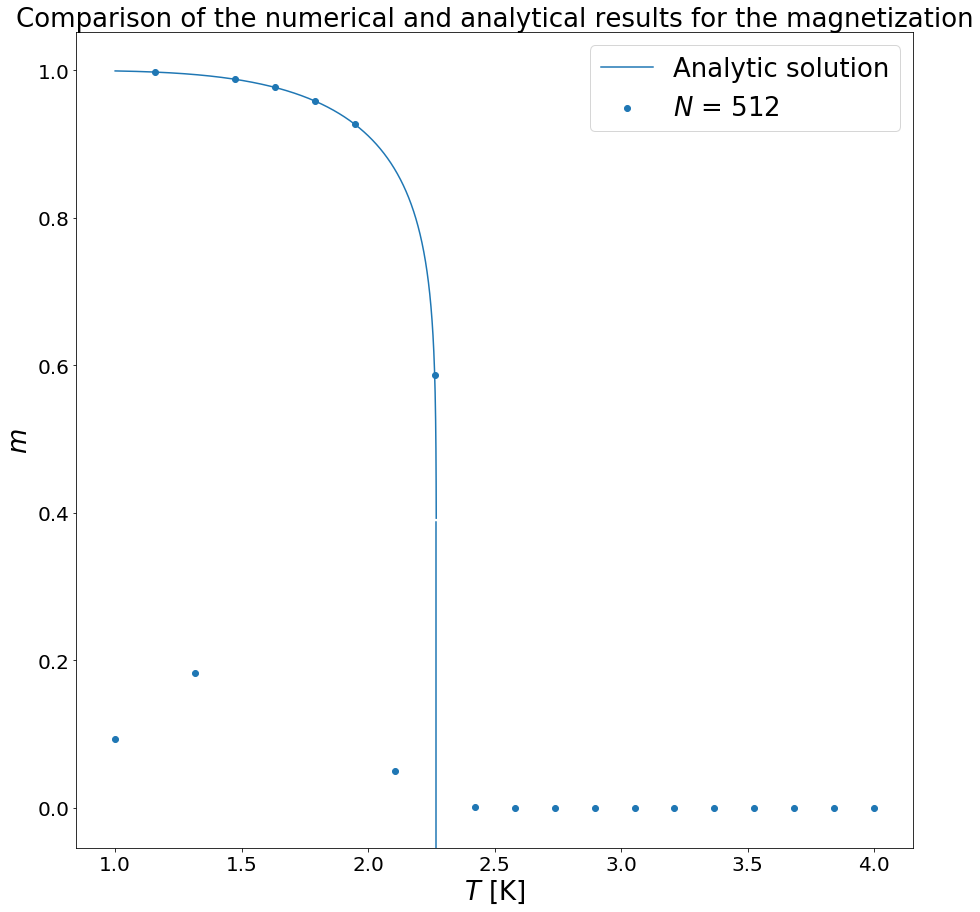

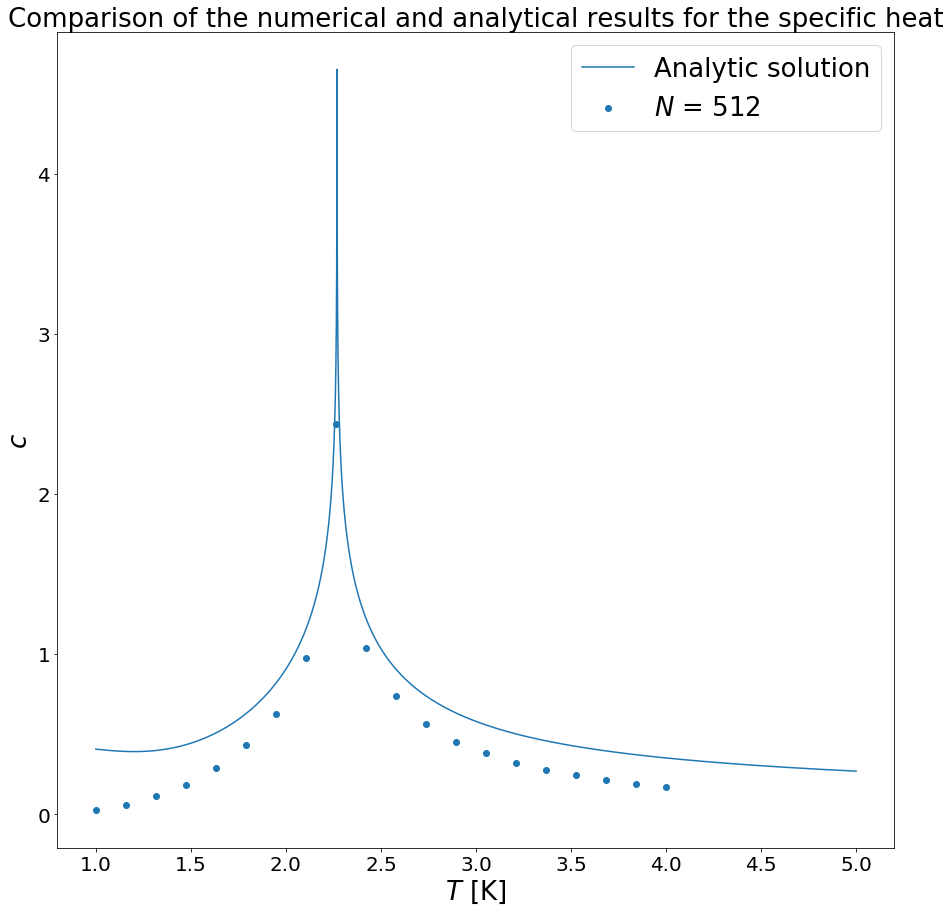

In [154]:
# Now let use an enormous lattice!
N = 512
m, c, T = full_simulation(20, N, 200000)


# Magnetization

plt.scatter(T, m, label=r"$N$ = 512")

T_2 = np.linspace(1, 5, 10000)
m_analytical = (1 - (np.sinh(2 / T_2)) ** (-4)) ** (1 / 8) # Onsager's analytical solution
plt.plot(T_2, m_analytical, label = "Analytic solution")
plt.axvline(2.269, ymax=0.4) # Adding vertical line to illustrate that the functions comes screaming down at T_c
plt.legend()
plt.title(r"Comparison of the numerical and analytical results for the magnetization")
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$m$")
plt.show()


# Specific heat
plt.scatter(T, c, label=r"$N$ = 512")

plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$c$")
plt.title(r"Comparison of the numerical and analytical results for the specific heat")
beta = 1 / T_2
# Assuming J_v = J_p = 1
J_v = 1
J_p = 1
kappa_1 = 2 * np.sinh(2 * beta * J_v) / (np.cosh(2 * J_v * beta) ** 2 )
kappa_2 = 2 * np.tanh(2 * beta * J_v) ** 2 - 1

elliptical_first_kind = ellipk(kappa_1)
elliptical_second_kind = ellipe(kappa_1)

C_v_analytical = 2 / np.pi * (beta * J_v) ** 2 / np.tanh(2 * beta * J_v) ** 2 *(
    2 * elliptical_first_kind - 2 * elliptical_second_kind -
     (1 - kappa_2) * (np.pi / 2 + kappa_2 * elliptical_first_kind))
plt.plot(T_2, C_v_analytical, label= "Analytic solution")
plt.legend()
plt.show()

Forklaring av figur over

Lars Onsager actually found the formula for the specific heat for general $J$ and $J'$, but the formula becomes way more complicated than equation $\eqref{C_B}$. We will therefore borrow one of his figures from his paper to compare with our numerical result. In this case we use $ J = 1$ while, $ J'$ will take the values 1, 0.01, and 0.

/home/niels/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/niels/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


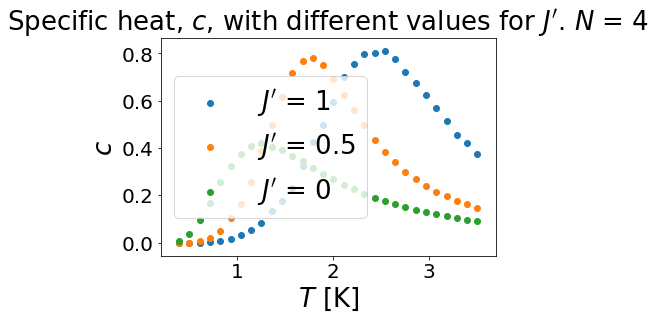

In [17]:
N = 128

J_p = 1
m, c, T = full_simulation(30, N, 100000, T_min = 0.4, T_max = 3.5, J_p = J_p)
plt.scatter(T, c, label= "$J'$ = {}".format(J_p))

J_p = 0.01
m, c, T = full_simulation(30, N, 100000, T_min = 0.4, T_max = 3.5, J_p = J_p)
plt.scatter(T, c, label= "$J'$ = {}".format(J_p))

J_p = 0
m, c, T = full_simulation(30, N, 100000, T_min = 0.4, T_max = 3.5, J_p = J_p)
plt.scatter(T, c, label= "$J'$ = {}".format(J_p))
    
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$c$")
plt.title(r"Specific heat, $c$, with different values for $J'$. $N$ = {}".format(N))
plt.legend()
plt.show()

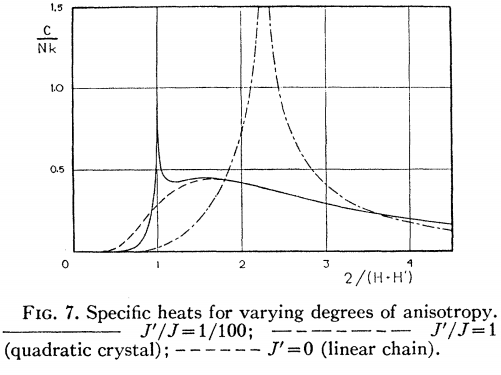

Forklaring av figur over

Now, let us for completeness run a simulation that has an external magnetic field and see how the lattice responds to this. Remember, as $B \neq 0$, Onsager's solution is not valid anymore, as mentioned earlier there is no known analytic solution for this problem. However, we can still try to make sense of the results from a physical perspective, and justify it's validity based on simple physical principles.

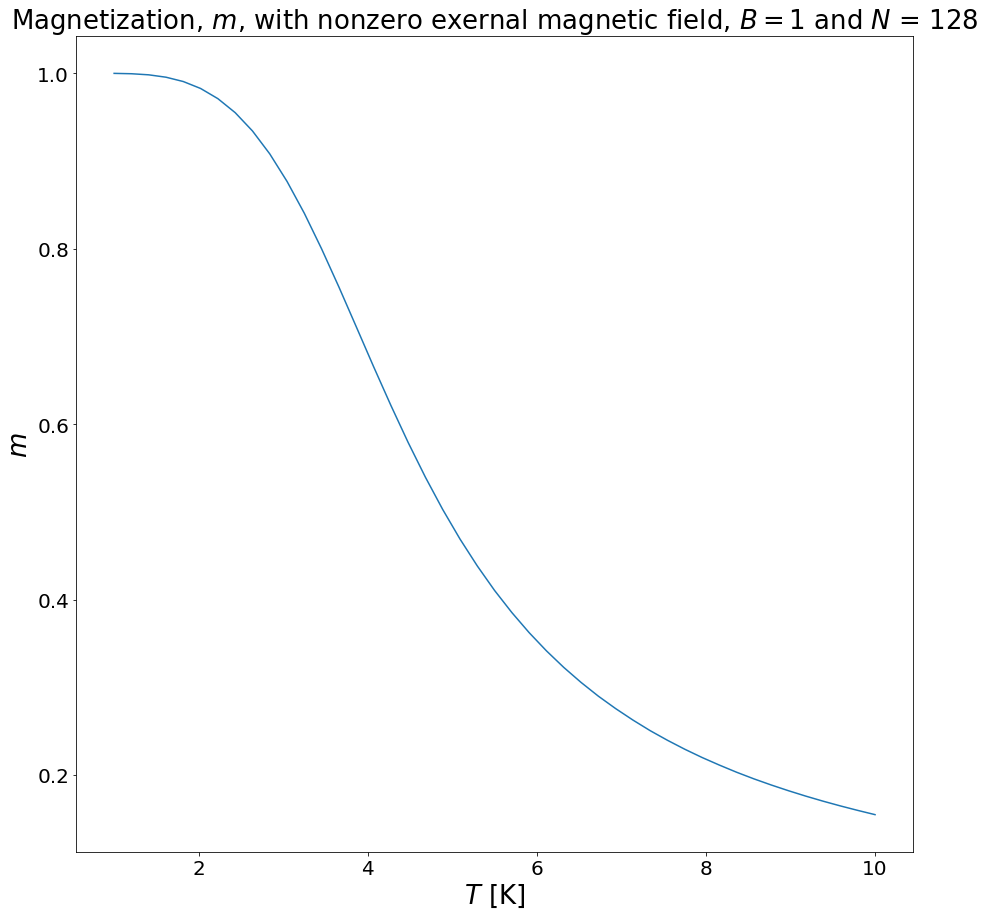

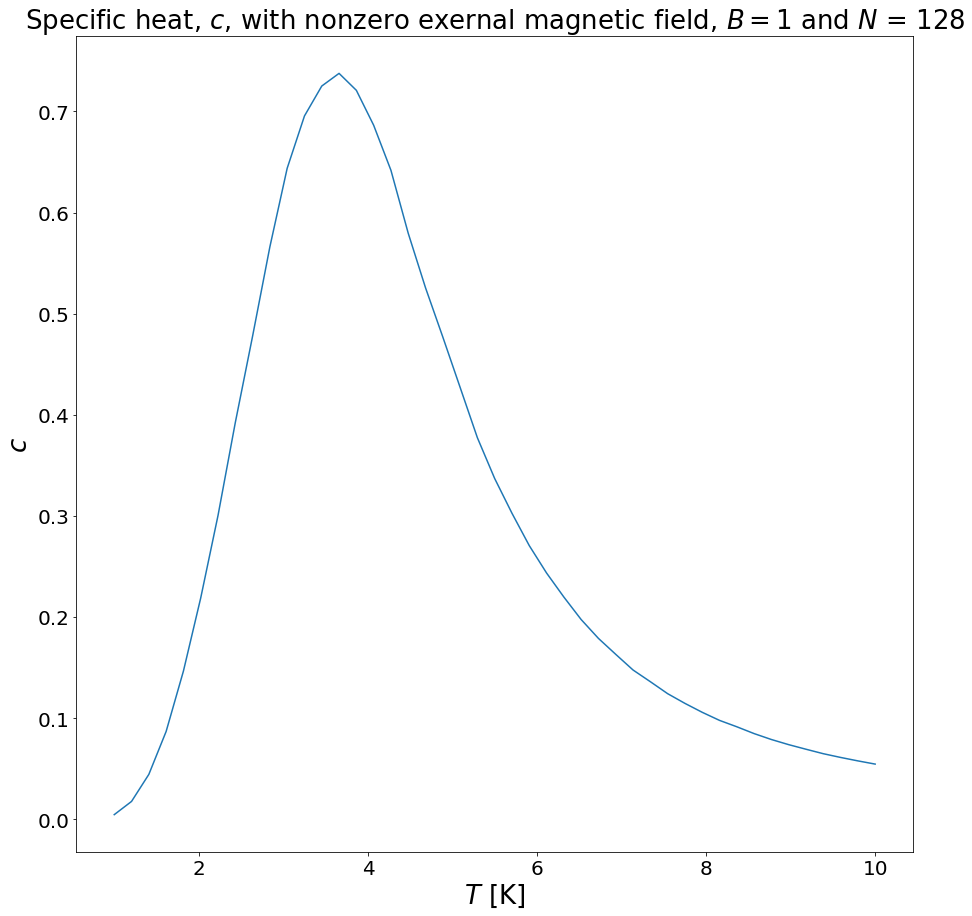

In [158]:
N = 128
m, c, T = full_simulation(45, N, 300000, B = 1, T_max = 10)

plt.plot(T, m)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$m$")
plt.title(r"Magnetization, $m$, with nonzero exernal magnetic field, $B=1$ and $N$ = {}".format(N))
plt.show()

plt.plot(T, c)
plt.xlabel(r"$T$ [K]")
plt.ylabel(r"$c$")
plt.title(r"Specific heat, $c$, with nonzero exernal magnetic field, $B=1$ and $N$ = {}".format(N))
plt.show()


Figur forklaring

### Critical exponents

As we have dedicated so much time to obtaining a lot of computational power, we want to use our model to find the critical exponents of the two-dimensional Ising model. Critical exponents describe the behavior of thermodynamic quantities near phase transitions. In higher dimensions, there has been done a lot work on determining precise estimates for the critical exponents. The critical exponents are extremely sensitive to deviations from the analytic result, so want to push our model to it's limits.

The critical exponent $\beta$ (not to be confused with the inverse temperature that we have been using $\beta$ to denote thus far) describes how the magnetization vanishes near $T_c$. In this temperature domain, the magnetization can be written as

$$ 
m \sim \epsilon |T-T_C|^\beta,
$$
where $\epsilon$ is some constant. By Taylor expanding the analytic solution for $m$, equation $\eqref{magnetization}$, one finds that the 2D infinite Ising model has $\beta = \frac{1}{8}$. Let us see how our model fares. 

In [ ]:
def mag_low_T(T, epsilon, beta):
    """
    Dummy function declariation that is needed to use the curve_fit function from the scipy library. 
    
        Parameters:
        T: Temperature
        epsilon: Fitting parameter
        beta: Fitting parameter, the critical exponent for magnetization with no external field
        Returns:
            m: epsilon * T ** beta
        """
    m = epsilon * T ** beta
    return m

def critical_exponent(K, N, sweeps, T_low, show_time = False):
    T_c = 2.26918
        
    T_2 = np.linspace(T_low, T_c, 10000)
    m_analytical = (1 - (np.sinh(2 / T_2)) ** (-4)) ** (1 / 8) # Onsager's analytical solution
    #plt.plot(np.absolute(T_2 - T_c), m_analytical, label = "Analytic solution")
    #plt.axvline(0, ymax=0.32) # Adding vertical line to illustrate that the functions comes screaming down at T_c
    #plt.title(r"Magnetization, $m$")
    #plt.xlabel(r"$T$ [K]")
    #plt.ylabel(r"$m$")
    
    T_list = np.linspace(T_low, T_c, K)
    m_list = full_simulation(K, N, sweeps, T_low, T_c)[0]
    deviation_from_T_c = np.absolute(T_list - T_c)
    beta = curve_fit(mag_low_T, deviation_from_T_c, m_list)[0][1]
    print("N = ", N, r" and beta = ", beta)
    return m_list, beta, T_list
    

m_64, beta_64, T_list_64 = critical_exponent(25, 64, 200000, 2)    
    
m_128, beta_128, T_list_128 = critical_exponent(25, 128, 200000, 2)

m_256, beta_256, T_list_256 = critical_exponent(25, 256, 200000, 2)



/home/niels/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


N =  64  and beta =  0.18961076538077562
N =  128  and beta =  0.11279311289016279


Forklaring av figur over


In this notebook we have used the Monte Carlo method, the perhaps most important computational statistical algorithm in all of physics. This suits well with the underlying physical system of the notebook, as the Ising model has been one of the most important models in statistical physics the last century. Thus, this is a topic where you can learn a lot of important principles regarding algorithms and computations that are still very relevant today!

To make your own Ising model is an excellent exercise, especially as it forces you to keep your code clean and efficient. With today's computers, it is easy to be careless when writing code, as it will most likely run more than fast enough. Our last function call, ran the most basic parts of the code 3 trillion times! Being proficient at a high-speed language such as Fortran is an excellent tool for a computational physicist to have. We recommend warmly the book by Newman and Barkema [[4]](#rsc), if you want to study more sophisticated Monte Carlo methods than the Metropolis-Algorithm and continue studying the various thermodynamic quantities of the Ising model such as for example the magnetic susceptibility, $\chi$ or if you want to expand the Ising model to three dimensions. There is still much to learn and do with the Ising model!



___
<a id="rsc"></a>
## Resources and further reading
<a>[1]</a>: L. Onsager, *Crystal Statistics. I. A Two-Dimensional Model with an Order-Disorder Transition*, American Physical Society, 1944. <br />
<a>[2]</a>: K. Huang, *Statistical Mechanics*, John Wiley & Sons, 1987. <br />
<a>[3]</a>: Yang, C. N, *The Spontaneous Magnetization of a Two-Dimensional Ising Model*, American Physical Society, 1952. <br />
<a>[4]</a>: Newman, M. E. J & Barkema, G. T, *Monte Carlo methods in Statistical Physics*, Oxford University Press, 1999. <br />